# Fréquentation de la bibliothèque des Champs Libres

Ce notebook est une analyse exploratoire des statistiques de fréquentation de la bibliothèque des champs libres mises à disposition par la plateforme ouverte des données publiques françaises. Le jeu de données est disponible [ici](https://www.data.gouv.fr/fr/datasets/statistiques-de-frequentation-de-la-bibliotheque-des-champs-libres-par-heure-2013-rm/). 

In [1]:
import re
import os
import time

import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import altair as alt
alt.data_transformers.enable("json")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

import requests

import warnings
warnings.filterwarnings("ignore")

## Lecture des données

Dans ce dataset, on distingue plusieurs types de variable :
- **zone** et **heure** sont des variables qualitatives, elles ne prennent pour valeur qu'un ensemble défini de valeur. 
- **comptage-entrées** est une variable quantitative qui ne prends que des valeurs entières dans l'interval \[1, 736]\, elle peut donc être codée dans un entier 16 bits.
- **période** est une date qui doit donc être parsée pour être pleinement utilisée.

In [2]:
dtypes = {
    "zone": "category",
    "heure": "category",
    "comptage-entrées": "int16"
}

df = pd.read_csv("frequentation_bibliotheque.csv", 
                 encoding="latin_1", 
                 sep=";",
                 dtype=dtypes,
                 parse_dates=["période"])

df.head()

,site,code insee,période,heure,zone,comptage - entrées
0,Rennes les champs libres,35238,2013-02-01,12:00,"1er étage vie du citoyen, 1er etage vie du cit...",10
1,Rennes les champs libres,35238,2013-02-01,12:00,"RdC champs libres, rdc 2",5
2,Rennes les champs libres,35238,2013-02-01,12:00,"RdC champs libres, rdc 3",207
3,Rennes les champs libres,35238,2013-02-01,12:00,"RdC champs libres, rdc 4",45
4,Rennes les champs libres,35238,2013-02-01,12:00,"RdC champs libres, rdc retour",11


**site** et **code insee** sont constantes, on peut donc les supprimer.

In [3]:
df = df.drop(["site", "code insee"], axis=1)

Pour des questions de confort et lisibilité, on supprime la partie minute (toujours égale à 00) de l'**heure** et la partie avant la virgule de la **zone**, et on renomme les variables en anglais.

In [4]:
df["zone"] = df["zone"].cat.rename_categories(
    [name.split(',')[1] for name in df["zone"].cat.categories]
)

df["heure"] = df["heure"].cat.rename_categories(
    [name.split(':')[0] for name in df["heure"].cat.categories]
)

df = df.rename({
    "période": "date",
    "heure": "hour",
    "comptage - entrées": "entry_count"
}, axis="columns")

df.head()

,date,hour,zone,entry_count
0,2013-02-01,12,1er etage vie du citoyen,10
1,2013-02-01,12,rdc 2,5
2,2013-02-01,12,rdc 3,207
3,2013-02-01,12,rdc 4,45
4,2013-02-01,12,rdc retour,11


## Analyse du compte des entrées


Entry count :

count    11060.000000
mean        66.455606
std         84.143666
min          1.000000
25%         11.000000
50%         32.000000
75%         86.000000
max        736.000000
Name: entry_count, dtype: float64


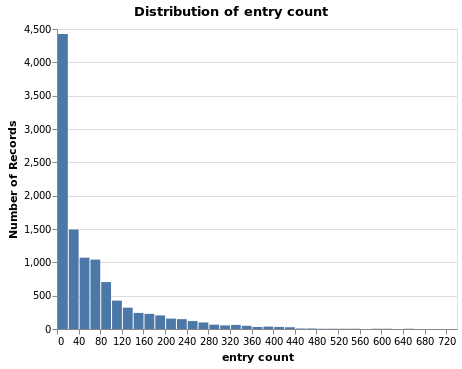

In [5]:
print("Entry count :\n")
print(df["entry_count"].describe())

alt.Chart(df, title="Distribution of entry count").mark_bar().encode(
    x=alt.X("entry_count", bin=alt.Bin(maxbins=50), title="entry count"),
    y="count()"
)

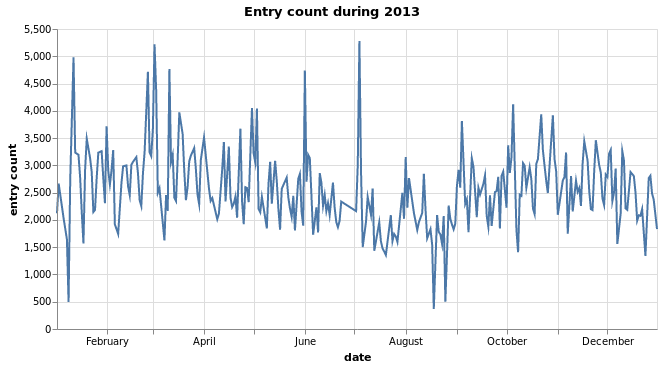

In [6]:
alt.Chart(df, width=600, title="Entry count during 2013").mark_line().encode(
    x="date",
    y=alt.X("sum(entry_count)", title="entry count")
)

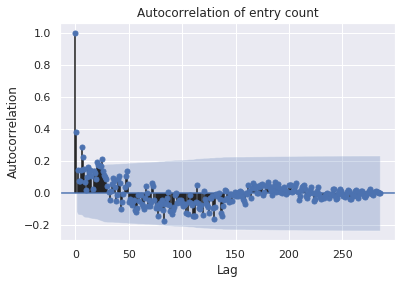

In [7]:
ax = plt.subplot()

plot_acf(df.groupby("date")["entry_count"].agg("sum"), ax=ax)

ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of entry count");

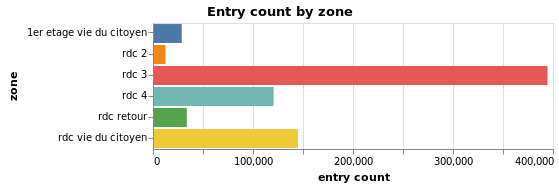

In [8]:
alt.Chart(df, title="Entry count by zone").mark_bar().encode(
    y="zone",
    x=alt.X("sum(entry_count)", title="entry count"),
    color=alt.Color("zone", legend=None),
)

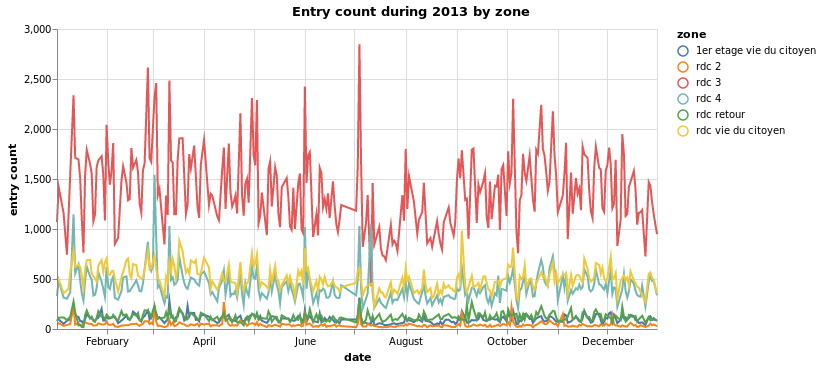

In [9]:
alt.Chart(df, width=600, title="Entry count during 2013 by zone").mark_line().encode(
    x="date",
    y=alt.Y("sum(entry_count)", title="entry count"),
    color="zone"
)

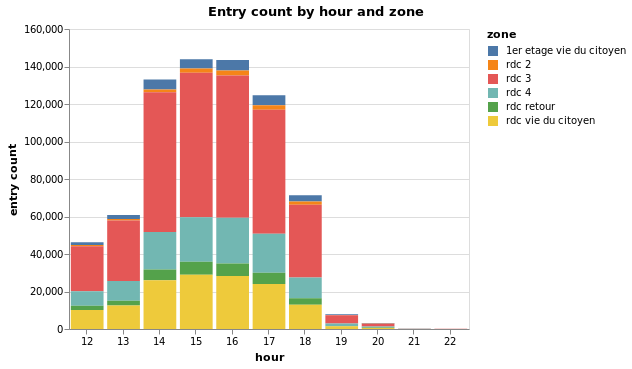

In [10]:
alt.Chart(df, width=400, title="Entry count by hour and zone").mark_bar().encode(
    x="hour",
    y=alt.Y("sum(entry_count)", title="entry count"),
    color="zone",
).configure_axis(labelAngle=0)

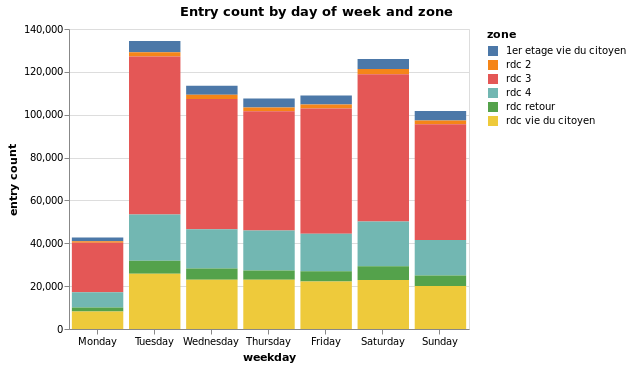

In [11]:
df["weekday"] = df["date"].dt.weekday_name.astype("category")
weekdays_sorted = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

alt.Chart(df, width=400, title="Entry count by day of week and zone").mark_bar().encode(
    x=alt.X("weekday", sort=weekdays_sorted),
    y=alt.Y("sum(entry_count)", title="entry count"),
    color="zone",
).configure_axis(labelAngle=0)

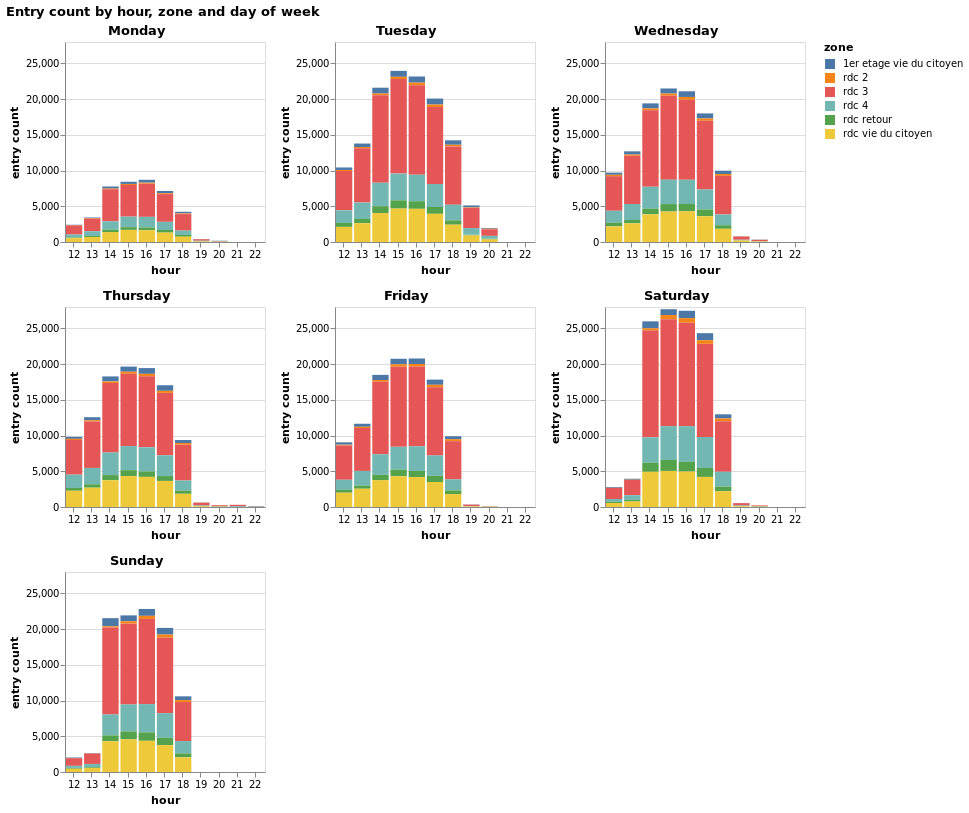

In [12]:
n_cols = 3

hour_domain = list(df["hour"].unique())
entry_count_domain = (0, df.groupby(["weekday", "hour"]).agg("sum")["entry_count"].max())
                                        
base = alt.Chart(df, width=200, height=200).mark_bar().encode(
    x=alt.X("hour:O", scale=alt.Scale(domain=hour_domain)),
    y=alt.Y("sum(entry_count):Q", scale=alt.Scale(domain=entry_count_domain), title="entry count"),
    color="zone",
)

chart = alt.vconcat(title="Entry count by hour, zone and day of week")

for i in range(0, len(weekdays_sorted), n_cols):
    row = alt.hconcat()
    
    for weekday in  weekdays_sorted[i:i+n_cols]:
        row |= base.properties(title=weekday).transform_filter(alt.datum.weekday == weekday)
        
    chart &= row
    
chart.configure_axis(labelAngle=0)

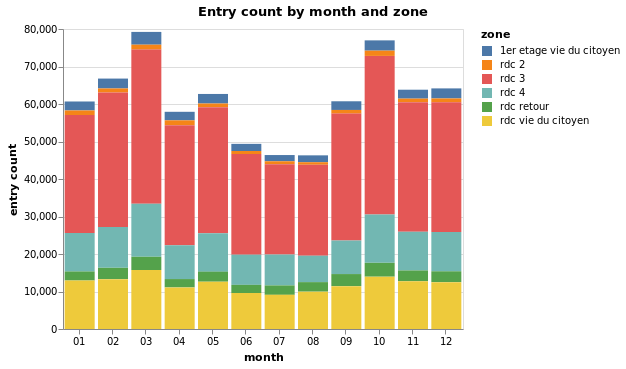

In [13]:
df["month"] = df["date"].dt.month.apply(lambda x: f"{x:02d}").astype("category")

alt.Chart(df, width=400, title="Entry count by month and zone").mark_bar().encode(
    x="month:O",
    y=alt.Y("sum(entry_count)", title="entry count"),
    color="zone",
).configure_axis(labelAngle=0)

Cette analyse exploratoire du jeu de données nous permet de constater visuellement que les différentes variables dont on dispose ont bel et bien une influence sur le nombre d'entrées et qu'elles peuvent donc être utile pour le prédire. On constate par exemple que : 

- il y a plus d'entrées au niveau de la zone rdc3 que dans les autres
- il y a moins d'entrées le lundi que les autres jours
- il y a plus d'entrées entre 13h et 18h qu'aux autres créneaux


## Prédiction du comptage des entrées

### Procédure d'évaluation

La procédure d'évaluation de nos modèles consiste à effectuer deux cross-validations pour calculer des estimations de la MAE (mean absolute error) et de la RMSE (root-mean-square-error). Il est intéressant d'utiliser les deux metriques car :

- la MAE indique la moyenne de toutes les erreurs et donne une idée générale des performances
- la RMSE met les erreurs au carré avant de faire la moyenne et donne donc plus de poids aux grandes erreurs
- Plus la différence entre la RMSE et la MAE est grande, plus la variance des erreurs est grande

Finalement, on affiche aussi l'importance de chaque variable selon la random forest entrainée avec les données.


In [14]:
N_CV = 50
PREFIX_SEP = "/"

def evaluate(clf, X, y):
    np.random.seed(0)
    mae = -cross_val_score(rf, X, y, cv=N_CV, scoring="neg_mean_absolute_error")
    
    np.random.seed(0)
    mse = -cross_val_score(rf, X, y, cv=N_CV, scoring="neg_mean_squared_error")
    rmse = np.sqrt(mse)
    
    clf.fit(X, y)
    
    display(pd.DataFrame({
        "mae": [np.mean(mae), np.std(mae)],
        "rmse": [np.mean(rmse), np.std(rmse)],   
    }, index=["mean", "std"]))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.distplot(mae, ax=ax1)
    sns.distplot(rmse, ax=ax1)
    ax1.legend(["mae", "rmse"])
    ax1.set_title(f"Distribution of MAE and RMSE on {N_CV}-fold cross-validation")
    
    (
        pd.DataFrame({
            "feature": [x[0] for x in X.columns.str.split(PREFIX_SEP)],
            "importance": clf.feature_importances_
        }).groupby("feature")
          .agg("sum")
          .sort_values("importance")
          .plot.barh(ax=ax2, title="Feature importances", legend=False)
    )
    
    return mae, rmse

rf = RandomForestRegressor(n_estimators=100)

 ### Random forest avec heure, jour de la semaine, mois, zone

,mae,rmse
mean,18.516313,34.651855
std,6.501734,14.652166


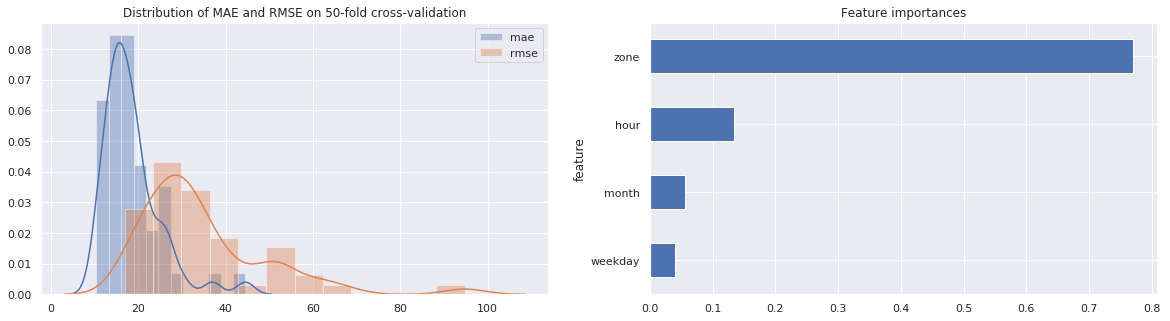

In [15]:
X1 = pd.get_dummies(df[["hour", "weekday", "month", "zone"]], prefix_sep=PREFIX_SEP)
y = df["entry_count"]

mae1, rmse1 = evaluate(rf, X1, y)

### Ajout de variables liées au climat

In [16]:
URL = "http://www.meteofrance.com/climat/meteo-date-passee"
LIEU_ID = 352380
LIEU_TYPE = "VILLE_FRANCE"

def get_weather_data(date):
    date = pd.to_datetime(date)
    date_str = f"{date.day:02}-{date.month:02}-{date.year}"
    params = {"lieuId": LIEU_ID, "lieuType": LIEU_TYPE, "date": date_str}

    r = requests.get(URL, params=params)

    text = r.text.replace("\n", " ")
    min_temperature, max_temperature = re.findall(r"(\d+\.\d+)°C", text)
    sunny_time = re.findall(r"(\d+)h", text)[0]

    hours = re.findall(r"(\d+ h)<", text)
    climates = re.findall(r'<span class="picTemps WW[\w]*"></span> ([\w ]*) ', text)

    return (
        float(min_temperature),
        float(max_temperature),
        int(sunny_time),
        {
            "climate_" + hour.replace(" ", ""): climate
            for hour, climate in zip(hours, climates)
        },
    )

In [17]:
if not os.path.exists("weather.csv"):
    weather_data = {
        "date": [],
        "min_temperature": [],
        "max_temperature": [],
        "sunny_time": [],
        "climate_11h": [],
        "climate_14h": [],
        "climate_17h": [],
    }

    for date in df["date"].unique():
        min_temperature, max_temperature, sunny_time, climates = get_weather_data(date)

        weather_data["date"].append(date)
        weather_data["min_temperature"].append(min_temperature)
        weather_data["max_temperature"].append(max_temperature)
        weather_data["sunny_time"].append(sunny_time)

        for hour in ["11h", "14h", "17h"]:
            key = "climate_" + hour
            weather_data[key].append(climates.get(key, None))
            
        time.sleep(1)
        print(date)
            
    pd.DataFrame(weather_data).to_csv("weather.csv")

In [18]:
df_weather = pd.read_csv("weather.csv", index_col="date", parse_dates=["date"])

df_weather["climate_11h"] = df_weather["climate_11h"].fillna("unknown").astype("category")
df_weather["climate_14h"] = df_weather["climate_14h"].fillna("unknown").astype("category")
df_weather["climate_17h"] = df_weather["climate_17h"].fillna("unknown").astype("category")

df_weather.head()

,climate_11h,climate_14h,climate_17h,max_temperature,min_temperature,sunny_time
date,,,,,,
2013-02-01,Bruine,Bruine,Bruine,12.5,7.1,0
2013-03-01,Très nuageux,Très nuageux,Très nuageux,4.8,1.3,0
2013-04-01,unknown,unknown,unknown,10.4,0.3,10
2013-05-01,unknown,Très nuageux,Bruine,14.3,7.9,3
2013-06-01,Très nuageux,unknown,unknown,18.7,8.9,8


In [19]:
df = df.join(df_weather, on='date')

df.head()

,date,hour,zone,entry_count,weekday,month,climate_11h,climate_14h,climate_17h,max_temperature,min_temperature,sunny_time
0,2013-02-01,12,1er etage vie du citoyen,10,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0
1,2013-02-01,12,rdc 2,5,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0
2,2013-02-01,12,rdc 3,207,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0
3,2013-02-01,12,rdc 4,45,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0
4,2013-02-01,12,rdc retour,11,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0


,mae,rmse
mean,17.592006,33.478397
std,5.345955,13.605709


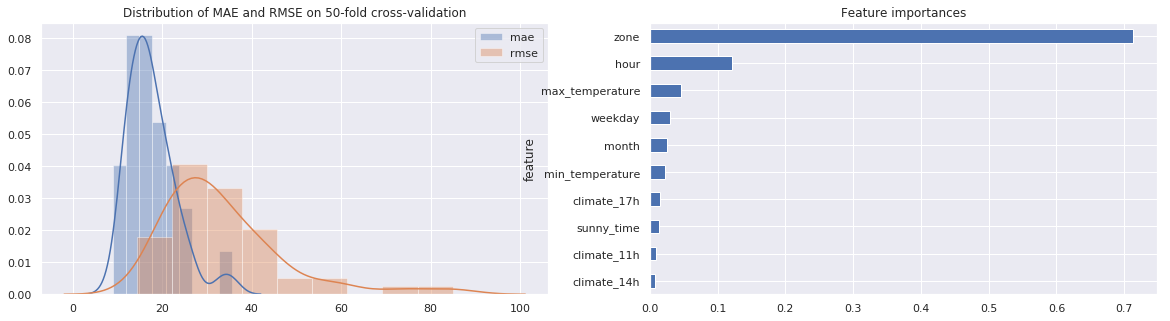

In [20]:
X2 = pd.get_dummies(df[["hour", 
                        "weekday", 
                        "month", 
                        "zone", 
                        "max_temperature", 
                        "min_temperature", 
                        "sunny_time", 
                        "climate_11h", 
                        "climate_14h",
                        "climate_17h"]], prefix_sep=PREFIX_SEP)

mae2, rmse2 = evaluate(rf, X2, y)

### Ajout des périodes de vacances

In [21]:
def date_in(s, start, end):
    return (s > start) & (s < end)

holidays = [
    ("2013/1/1", "2013/1/7"),
    ("2013/2/23", "2013/3/11"),
    ("2013/4/20", "2013/5/6"),
    ("2013/7/4", "2013/9/3"),
    ("2013/10/19", "2013/11/4"),
    ("2013/12/21", "2014/1/6")
]

df["is_holiday"] = False

for day_start, day_end in holidays:
    df.loc[date_in(df["date"], 
                   pd.to_datetime(day_start), 
                   pd.to_datetime(day_end)), "is_holiday"] = True


df.head()

,date,hour,zone,entry_count,weekday,month,climate_11h,climate_14h,climate_17h,max_temperature,min_temperature,sunny_time,is_holiday
0,2013-02-01,12,1er etage vie du citoyen,10,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0,False
1,2013-02-01,12,rdc 2,5,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0,False
2,2013-02-01,12,rdc 3,207,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0,False
3,2013-02-01,12,rdc 4,45,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0,False
4,2013-02-01,12,rdc retour,11,Friday,02,Bruine,Bruine,Bruine,12.5,7.1,0,False


,mae,rmse
mean,17.091462,32.435374
std,5.303358,13.471200


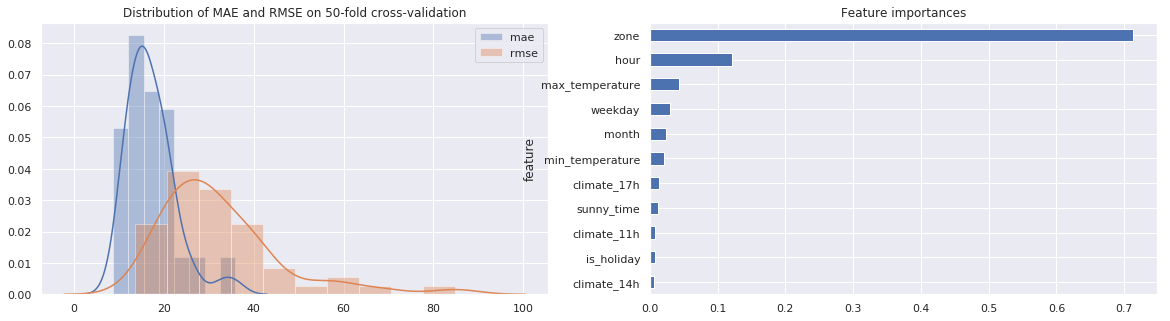

In [22]:
X3 = pd.get_dummies(df[["hour", 
                        "weekday", 
                        "month", 
                        "zone", 
                        "max_temperature", 
                        "min_temperature", 
                        "sunny_time", 
                        "climate_11h", 
                        "climate_14h", 
                        "climate_17h",
                        "is_holiday"]], prefix_sep=PREFIX_SEP)

mae3, rmse3 = evaluate(rf, X3, y)

### Comparaison des modèles - A/B testing

#### Avec la MAE

In [23]:
with pm.Model() as model: 
    mu1 = pm.Uniform("mu1", 0, 50)
    sd1 = pm.Uniform("sd1", 0, 50)
    M1 = pm.Normal("M1", mu=mu1, sd=sd1, observed=mae1)
    
    mu2 = pm.Uniform("mu2", 0, 50)
    sd2 = pm.Uniform("sd2", 0, 50)
    M2 = pm.Normal("M2", mu=mu2, sd=sd2, observed=mae2)
    
    mu3 = pm.Uniform("mu3", 0, 50)
    sd3 = pm.Uniform("sd3", 0, 50)
    M3 = pm.Normal("M3", mu=mu3, sd=sd3, observed=mae3)
    
    M1vM2 = pm.Deterministic("M1vM2", mu1 - mu2)
    M1vM3 = pm.Deterministic("M1vM3", mu1 - mu3)
    M2vM3 = pm.Deterministic("M2vM3", mu2 - mu3)
    
    start = pm.find_MAP()
    trace = pm.sample(20000, tune=10000, start=start, cores=4)
    burned_trace = trace[10000::2]

logp = -497.34, ||grad|| = 6.3501: 100%|██████████| 18/18 [00:00<00:00, 1128.19it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd3, mu3, sd2, mu2, sd1, mu1]
Sampling 4 chains: 100%|██████████| 120000/120000 [04:26<00:00, 450.57draws/s]


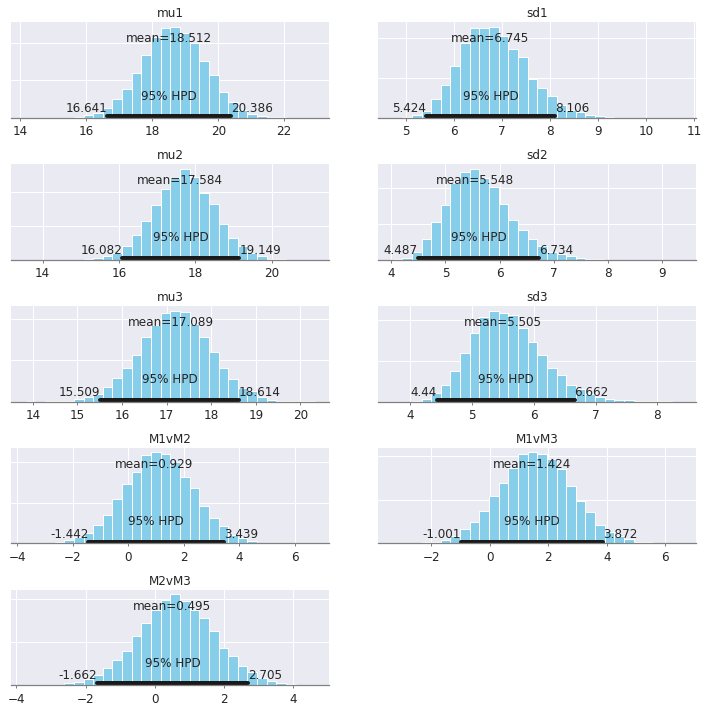

In [24]:
pm.plot_posterior(burned_trace, figsize=(10, 10));

In [25]:
print(f"Probability that model 2 is better than model 1 : {(burned_trace['M1vM2'] > 0).mean():.2f}")
print(f"Probability that model 3 is better than model 1 : {(burned_trace['M1vM3'] > 0).mean():.2f}")
print(f"Probability that model 3 is better than model 2 : {(burned_trace['M2vM3'] > 0).mean():.2f}")

Probability that model 2 is better than model 1 : 0.77
Probability that model 3 is better than model 1 : 0.87
Probability that model 3 is better than model 2 : 0.68


#### Avec la RMSE

In [26]:
with pm.Model() as model: 
    mu1 = pm.Uniform("mu1", 0, 50)
    sd1 = pm.Uniform("sd1", 0, 50)
    M1 = pm.Normal("M1", mu=mu1, sd=sd1, observed=rmse1)
    
    mu2 = pm.Uniform("mu2", 0, 50)
    sd2 = pm.Uniform("sd2", 0, 50)
    M2 = pm.Normal("M2", mu=mu2, sd=sd2, observed=rmse2)
    
    mu3 = pm.Uniform("mu3", 0, 50)
    sd3 = pm.Uniform("sd3", 0, 50)
    M3 = pm.Normal("M3", mu=mu3, sd=sd3, observed=rmse3)
    
    M1vM2 = pm.Deterministic("M1vM2", mu1 - mu2)
    M1vM3 = pm.Deterministic("M1vM3", mu1 - mu3)
    M2vM3 = pm.Deterministic("M2vM3", mu2 - mu3)
    
    start = pm.find_MAP()
    trace = pm.sample(20000, tune=10000, start=start)
    burned_trace = trace[10000::2]

logp = -631.09, ||grad|| = 0.010894: 100%|██████████| 13/13 [00:00<00:00, 797.02it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd3, mu3, sd2, mu2, sd1, mu1]
100%|██████████| 30000/30000 [00:34<00:00, 865.24it/s] 


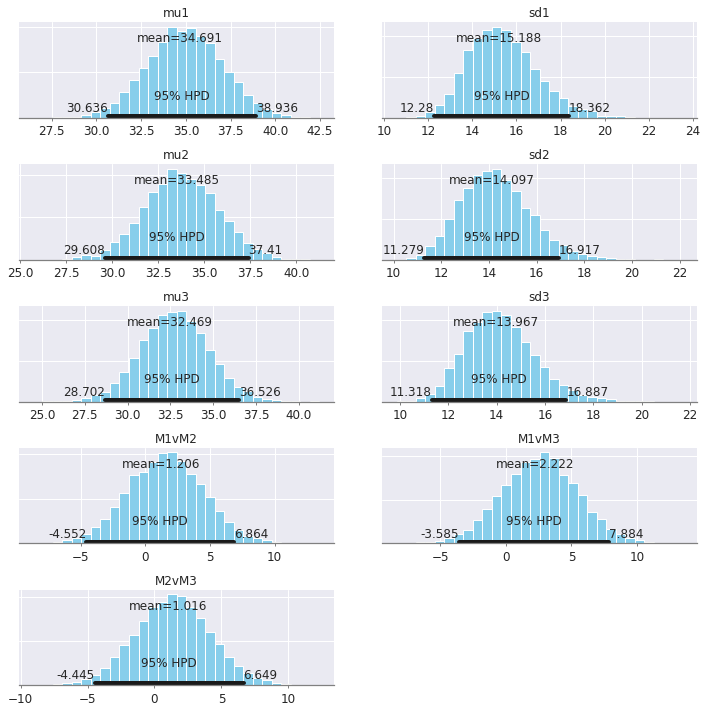

In [27]:
pm.plot_posterior(burned_trace, figsize=(10, 10));

In [28]:
print(f"Probability that model 2 is better than model 1 : {(burned_trace['M1vM2'] > 0).mean():.2f}")
print(f"Probability that model 3 is better than model 1 : {(burned_trace['M1vM3'] > 0).mean():.2f}")
print(f"Probability that model 3 is better than model 2 : {(burned_trace['M2vM3'] > 0).mean():.2f}")

Probability that model 2 is better than model 1 : 0.66
Probability that model 3 is better than model 1 : 0.78
Probability that model 3 is better than model 2 : 0.64


### Analyse des erreurs du modèle

In [29]:
df_random = df.sample(frac=1)

X4 = pd.get_dummies(df_random[["hour", 
                               "weekday", 
                               "month", 
                               "zone", 
                               "max_temperature", 
                               "min_temperature", 
                               "sunny_time", 
                               "climate_11h", 
                               "climate_14h", 
                               "climate_17h",
                               "is_holiday"]], prefix_sep=PREFIX_SEP)


y4 = df_random["entry_count"]

split = int(len(df_random) * 0.8)

X_train, y_train = X4[:split], y4[:split]
X_test, y_test = X4[split:], y4[split:]

rf.fit(X4, y4)
y_pred = np.round(rf.predict(X_test))

Min error: 0.00
Max error: 80.00
Mean error: 4.33

25% of the errors below 1.00
50% of the errors below 2.00
75% of the errors below 5.00
80% of the errors below 6.00
90% of the errors below 10.00
95% of the errors below 16.00


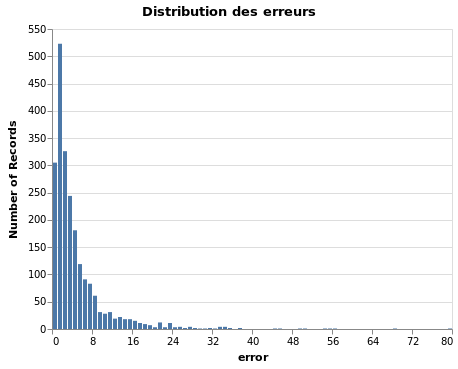

In [30]:
df_res = pd.DataFrame({
    "y_pred": y_pred,
    "y_true": y_test,
    "error": np.abs(y_test - y_pred)
})

df_res = df_res.join(df)



print(f"Min error: {df_res['error'].min():.2f}")
print(f"Max error: {df_res['error'].max():.2f}")
print(f"Mean error: {df_res['error'].mean():.2f}")
print()
print(f"25% of the errors below {df_res['error'].quantile(0.25):.2f}")
print(f"50% of the errors below {df_res['error'].quantile(0.50):.2f}")
print(f"75% of the errors below {df_res['error'].quantile(0.75):.2f}")
print(f"80% of the errors below {df_res['error'].quantile(0.8):.2f}")
print(f"90% of the errors below {df_res['error'].quantile(0.9):.2f}")
print(f"95% of the errors below {df_res['error'].quantile(0.95):.2f}")

alt.Chart(df_res, title="Distribution des erreurs").mark_bar().encode(
    x=alt.X("error", bin=alt.Bin(maxbins=100), title="error"),
    y="count()"
)

#### 10 plus grandes erreurs

In [31]:
df_res.nlargest(10, "error")

,y_pred,y_true,error,date,hour,zone,entry_count,weekday,month,climate_11h,climate_14h,climate_17h,max_temperature,min_temperature,sunny_time,is_holiday
2086,595.0,675,80.0,2013-03-03,16,rdc 3,675,Sunday,03,Très nuageux,Très nuageux,unknown,6.4,0.7,4,True
9316,125.0,57,68.0,2013-07-11,17,rdc 4,57,Thursday,07,Très nuageux,unknown,unknown,25.1,14.0,9,True
2794,420.0,476,56.0,2013-03-24,14,rdc 3,476,Sunday,03,unknown,unknown,Très nuageux,12.9,2.6,4,False
1117,211.0,156,55.0,2013-03-02,14,rdc 4,156,Saturday,03,Très nuageux,Très nuageux,Très nuageux,3.6,2.3,0,True
3266,192.0,246,54.0,2013-07-04,18,rdc 3,246,Thursday,07,Très nuageux,Très nuageux,unknown,25.1,11.6,4,False
7977,136.0,86,50.0,2013-09-26,22,rdc 3,86,Thursday,09,unknown,Eclaircies,unknown,25.0,13.4,3,False
10126,574.0,623,49.0,2013-01-12,16,rdc 3,623,Saturday,01,Très nuageux,unknown,Eclaircies,10.3,5.0,4,False
3308,179.0,224,45.0,2013-09-04,18,rdc 3,224,Wednesday,09,unknown,unknown,unknown,31.9,9.9,13,False
9129,416.0,460,44.0,2013-02-11,14,rdc 3,460,Monday,02,unknown,Très nuageux,unknown,10.2,0.6,6,False
8553,183.0,220,37.0,2013-10-15,19,rdc 3,220,Tuesday,10,Bruine,Bruine,Très nuageux,16.2,10.8,0,False


#### 10 plus petites erreurs

In [32]:
df_res.nsmallest(10, "error")

,y_pred,y_true,error,date,hour,zone,entry_count,weekday,month,climate_11h,climate_14h,climate_17h,max_temperature,min_temperature,sunny_time,is_holiday
6927,132.0,132,0.0,2013-08-24,18,rdc 3,132,Saturday,08,Très nuageux,Très nuageux,Très nuageux,20.0,15.2,2,True
5498,9.0,9,0.0,2013-06-16,17,rdc 2,9,Sunday,06,Très nuageux,Très nuageux,unknown,21.1,10.8,3,False
1416,234.0,234,0.0,2013-12-02,17,rdc 3,234,Monday,12,Très nuageux,Eclaircies,Très nuageux,9.3,1.0,1,False
5372,12.0,12,0.0,2013-06-13,13,1er etage vie du citoyen,12,Thursday,06,Bruine,Très nuageux,unknown,20.0,12.9,5,False
5116,5.0,5,0.0,2013-05-06,17,rdc 2,5,Monday,05,unknown,unknown,unknown,22.4,6.6,11,False
5745,14.0,14,0.0,2013-09-07,13,1er etage vie du citoyen,14,Saturday,09,unknown,unknown,Très nuageux,21.8,8.6,10,False
8492,11.0,11,0.0,2013-10-13,16,rdc 2,11,Sunday,10,unknown,Très nuageux,unknown,15.7,2.7,7,False
5397,6.0,6,0.0,2013-06-13,17,rdc 2,6,Thursday,06,Bruine,Très nuageux,unknown,20.0,12.9,5,False
9270,94.0,94,0.0,2013-06-11,16,rdc vie du citoyen,94,Tuesday,06,Très nuageux,Très nuageux,Très nuageux,18.0,13.6,0,False
3174,12.0,12,0.0,2013-05-04,13,1er etage vie du citoyen,12,Saturday,05,unknown,unknown,Très nuageux,19.4,3.3,9,True


## Visualisation d'un des arbres de décision

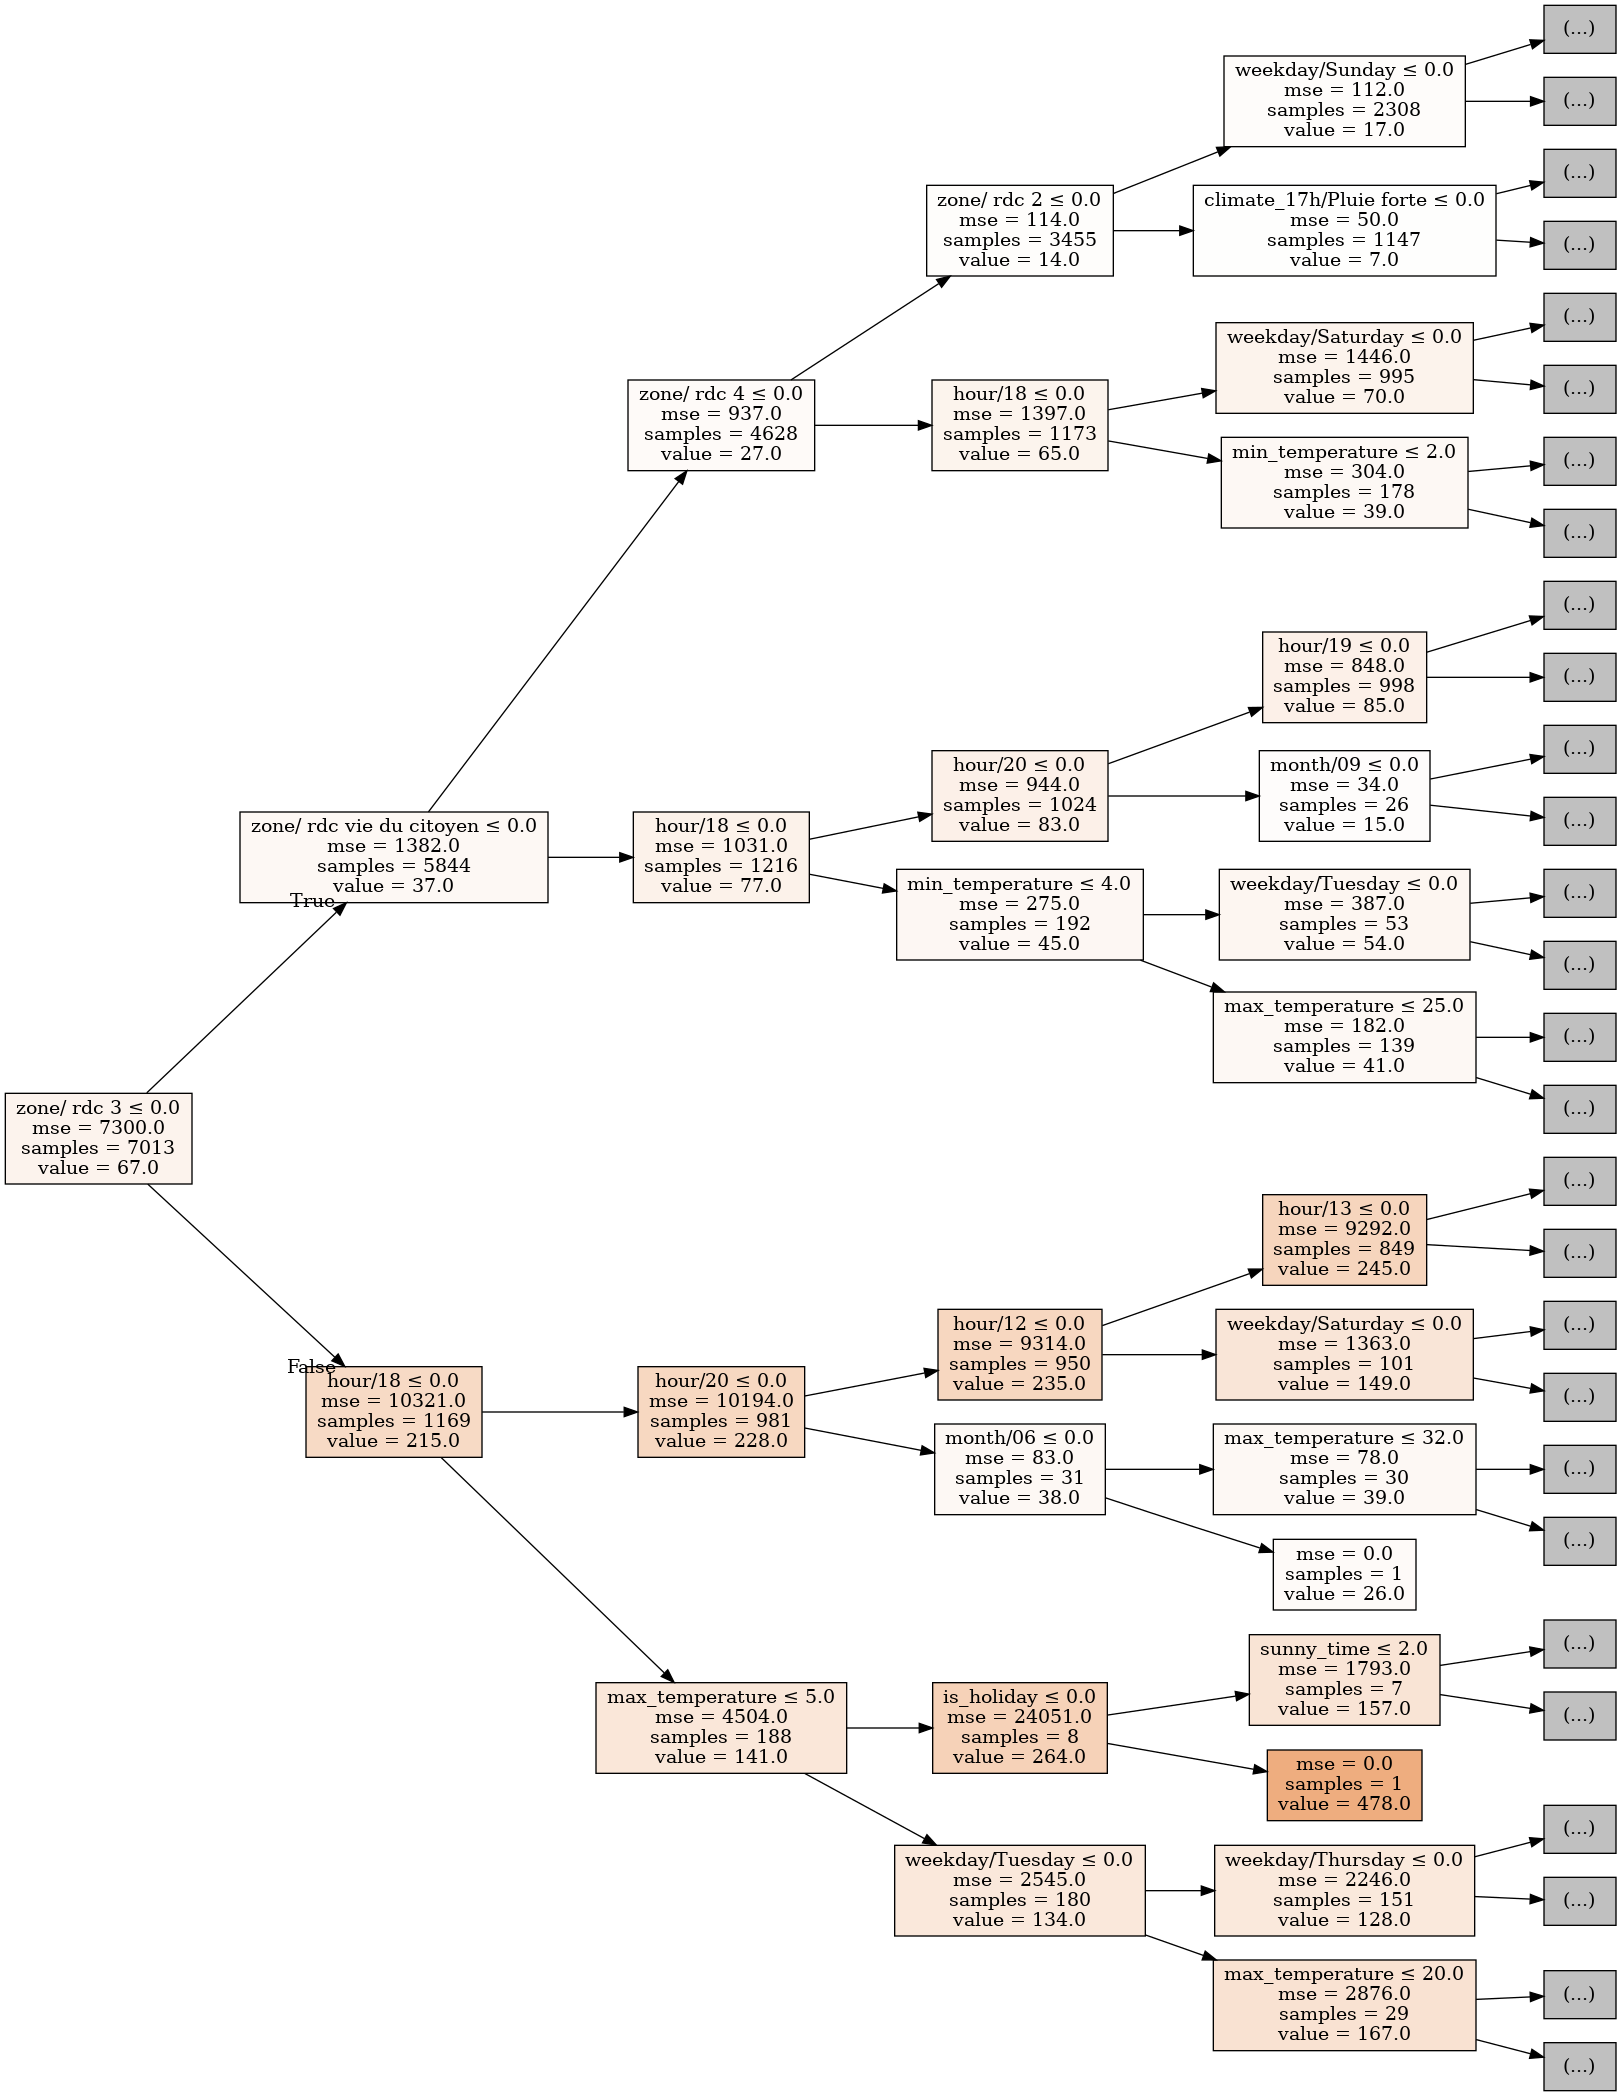

In [33]:
from sklearn.tree import export_graphviz
from IPython.display import Image

def draw_tree(t, X, size=10, ratio=0.6, precision=0):
    s = export_graphviz(
            t, 
            out_file="tree.dot", 
            feature_names=X.columns, 
            filled=True, 
            special_characters=True, 
            rotate=True, 
            precision=precision, 
            max_depth=4
    )
    
draw_tree(rf.estimators_[0], X4)
! dot -Tpng tree.dot -o tree.png && rm tree.dot
Image(filename="tree.png")